In [31]:
# Importing Libraries
import numpy as np
import scipy as sp 
import scipy.ndimage as ndimage
import math
import cv2
import matplotlib.pyplot as plt
import os

In [32]:

# Function for Resizing
def resize(img):
    ratio  = min([1152/img.shape[0], 1500/img.shape[1]])
    return cv2.resize(img,(int(img.shape[1]*ratio),int(img.shape[0]*ratio)), interpolation = cv2.INTER_CUBIC)

# Function for Adaptive Histogram Equalization
def clahe_equalized(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(10, 10))
    cl1 = clahe.apply(img)
    return cl1

# Function for Visualising Images
def imshow(img):
    plt.axis('off')
    plt.imshow(img, 'gray')
    plt.show()

# Function for Nearest Neighbour Resize
def nearest_neighbor_resize(img, new_w, new_h):
    # Dimensions of the New Image
    h, w = img.shape[0], img.shape[1]
    # New Image with RGB Channel
    ret_img = np.zeros(shape=(new_h, new_w), dtype='uint8')
    # Scale Factor
    s_h, s_c = (h * 1.0) / new_h, (w * 1.0) / new_w
    # Inserting Pixel to New Image
    for i in range(new_h):
        for j in range(new_w):
            p_x = int(i * s_c)
            p_y = int(j * s_h)
            ret_img[i, j] = img[p_x, p_y]
    return ret_img

# Evaluation Metrics - To Measure the Sensitivity
def evaluation(image, mask):

    zeros_list_img, one_list_img, zeros_list_mk, one_list_mk = [], [], [], []
    for i in range(0,image.shape[0]):
        for j in range(0,image.shape[1]):
            val_mk = mask[i][j]
            val_img  = image[i][j]
            if val_mk == 0:
                zeros_list_mk.append((i,j))
            else:
                one_list_mk.append((i,j))
            if val_img == 0:
                zeros_list_img.append((i,j))
            else:
                one_list_img.append((i,j))

    TP = len(set(one_list_img).intersection(set(one_list_mk)))
    TN = len(set(zeros_list_img).intersection(set(zeros_list_mk)))
    FP = len(set(one_list_img).intersection(set(zeros_list_mk)))
    FN = len(set(zeros_list_img).intersection(set(one_list_mk)))
    R = TP/(TP + FN)
    return R

55
data/images/test/IDRiD_55.jpg
Hard Exudates Detection: 


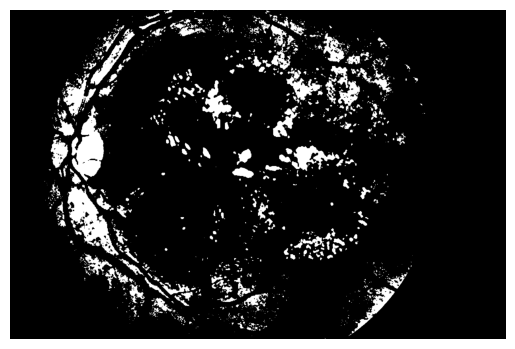

Hard Exudates Labels: 


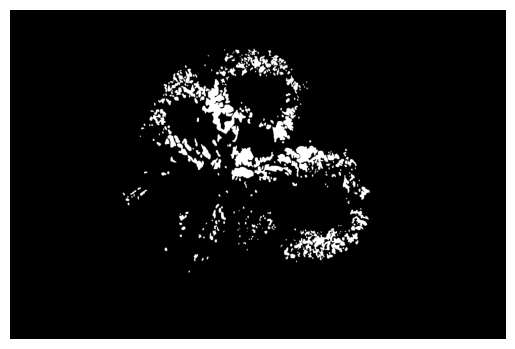

------------------------
R = 50.63586184447155
56
data/images/test/IDRiD_56.jpg
Hard Exudates Detection: 


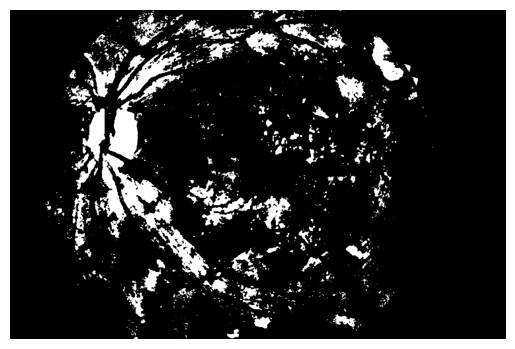

Hard Exudates Labels: 


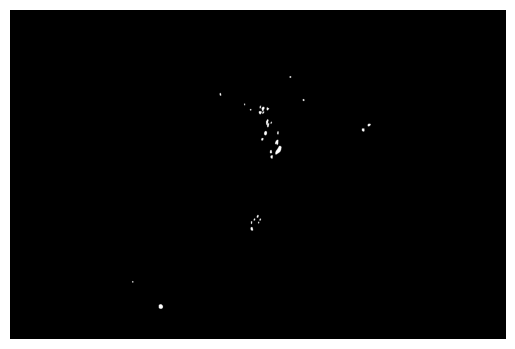

------------------------
R = 70.51608077786088
57
data/images/test/IDRiD_57.jpg
Hard Exudates Detection: 


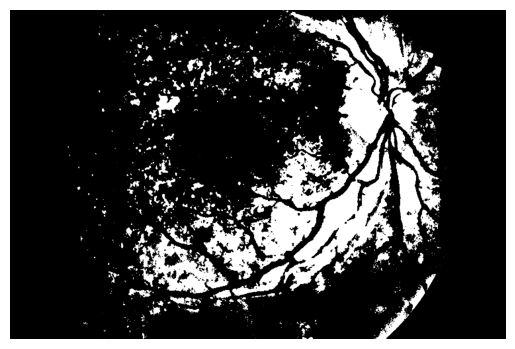

Hard Exudates Labels: 


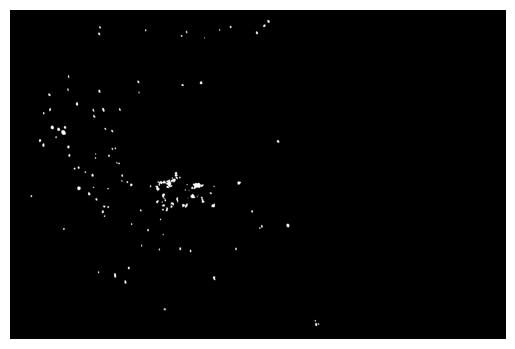

------------------------


In [33]:
for img_number in range(55,82,1):
  
  # Image Path
  image_path = "data/images/test/"
  images = os.listdir(image_path)
  images.sort()
  print(img_number)
  print(image_path + "IDRiD_" + str(img_number) + ".jpg" )
  # Reading Image
  img_file = image_path + "IDRiD_" + str(img_number) + ".jpg" #images[img_number]
  img = cv2.imread(img_file)
  img = resize(img)
  b,g,r = cv2.split(img)

  # Label Path
  ex_labels_path = "data/groundtruths/test/hard exudates/"
  ex_labels = os.listdir(ex_labels_path)
  ex_labels.sort()

  # Reading Mask
  ex_file = ex_labels_path + "IDRiD_" + str(img_number) + "_EX.tif"
  img_ex = cv2.imread(ex_file)
  img_ex_gray = cv2.cvtColor(img_ex, cv2.COLOR_BGR2GRAY)

  # LAB Color Space Transformation
  img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
  L,a,b = cv2.split(img_lab)
  ret, img_labt = cv2.threshold(L, 40, 255, cv2.THRESH_BINARY)
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
  img_erode = cv2.erode(img_labt, kernel, iterations=2)
  img_erode = ndimage.binary_fill_holes(img_erode)
  img_erode = np.array(img_erode,np.uint8)

  # Pipeline - Original Images
  img_med = cv2.medianBlur(g,3)
  img_enhanced = clahe_equalized(img_med)
  kernel_bh = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(200,200))
  img_bh = cv2.morphologyEx(img_enhanced,cv2.MORPH_BLACKHAT, kernel_bh)
  kernel_th = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(200,200))
  img_th = cv2.morphologyEx(img_enhanced,cv2.MORPH_TOPHAT, kernel_th)
  img_ex = cv2.subtract(img_th,img_bh)
  ret, img_ex_patch = cv2.threshold(img_ex, 50, 255, cv2.THRESH_BINARY)

  # Pipeline - Halved Images
  g_half = cv2.resize(g,(int(img.shape[1]/2),int(img.shape[0]/2)),interpolation = cv2.INTER_CUBIC)
  img_med_half = cv2.medianBlur(g_half,3)
  img_enhanced_half = clahe_equalized(img_med_half)
  img_bh_half = cv2.morphologyEx(img_enhanced_half,cv2.MORPH_BLACKHAT, kernel_bh)
  img_th_half = cv2.morphologyEx(img_enhanced_half,cv2.MORPH_TOPHAT, kernel_th)
  img_ex_half = cv2.subtract(img_th_half,img_bh_half)
  ret, img_ex_patch_half = cv2.threshold(img_ex_half, 50, 255, cv2.THRESH_BINARY)
  img_ex_patch_half = nearest_neighbor_resize(img_ex_patch_half,img_ex_patch.shape[1],img_ex_patch.shape[0])

  # Bitwise Operation of both the pipelines
  img_both = cv2.bitwise_or(img_ex_patch,img_ex_patch_half)
  # Bitwise Operation of the above patch and the eroded lightness patch
  img_both = cv2.bitwise_and(img_both,img_erode)
  # Resizing to Original
  img_both = cv2.resize(img_both, (4288,2848), interpolation=cv2.INTER_CUBIC)

  # # Matching and Evaluating the Results
  print('Hard Exudates Detection: ')
  imshow(img_both)
  
  print('Hard Exudates Labels: ')
  imshow(img_ex_gray)

  print('------------------------')
  R = evaluation(img_both, img_ex_gray)
  print('R = ', end = '')
  print(R*100)

  # Saving the Segmented Images
  cv2.imwrite("data/EX/" + 'IDRiD_' + str(img_number) + '_EX_s.png', img_both)